<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 12:51:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   32C    P0    28W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6251749270013534
GPU (s):
0.030555788020137697
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.vgg19.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.vgg19.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
80150528/80134624 [==============================] - 64s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 21s 49ms/step - loss: 1.0315 - accuracy: 0.6464 - val_loss: 0.6075 - val_accuracy: 0.7345
Epoch 2/100
360/360 [==============================] - 18s 49ms/step - loss: 0.6612 - accuracy: 0.7099 - val_loss: 0.5657 - val_accuracy: 0.7555
Epoch 3/100
360/360 [==============================] - 16s 46ms/step - loss: 0.6116 - accuracy: 0.7345 - val_loss: 0.5816 - val_accuracy: 0.7320
Epoch 4/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5905 - accuracy: 0.7348 - val_loss: 0.5373 - val_accuracy: 0.7690
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5724 - accuracy: 0.7489 - val_loss: 0.5237 - val_accuracy: 0.7716
Epoch 6/100
360/360

360/360 [==============================] - 15s 43ms/step - loss: 0.4252 - accuracy: 0.8226 - val_loss: 0.4655 - val_accuracy: 0.8097
Epoch 55/100
360/360 [==============================] - 15s 42ms/step - loss: 0.4286 - accuracy: 0.8193 - val_loss: 0.4566 - val_accuracy: 0.8117
Epoch 56/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4250 - accuracy: 0.8237 - val_loss: 0.4422 - val_accuracy: 0.8189
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4258 - accuracy: 0.8206 - val_loss: 0.4492 - val_accuracy: 0.8192
Epoch 58/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4181 - accuracy: 0.8227 - val_loss: 0.4438 - val_accuracy: 0.8176
Epoch 59/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4205 - accuracy: 0.8284 - val_loss: 0.4306 - val_accuracy: 0.8286
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4199 - accuracy: 0.8242 - val_loss: 0.4451 - val_accuracy

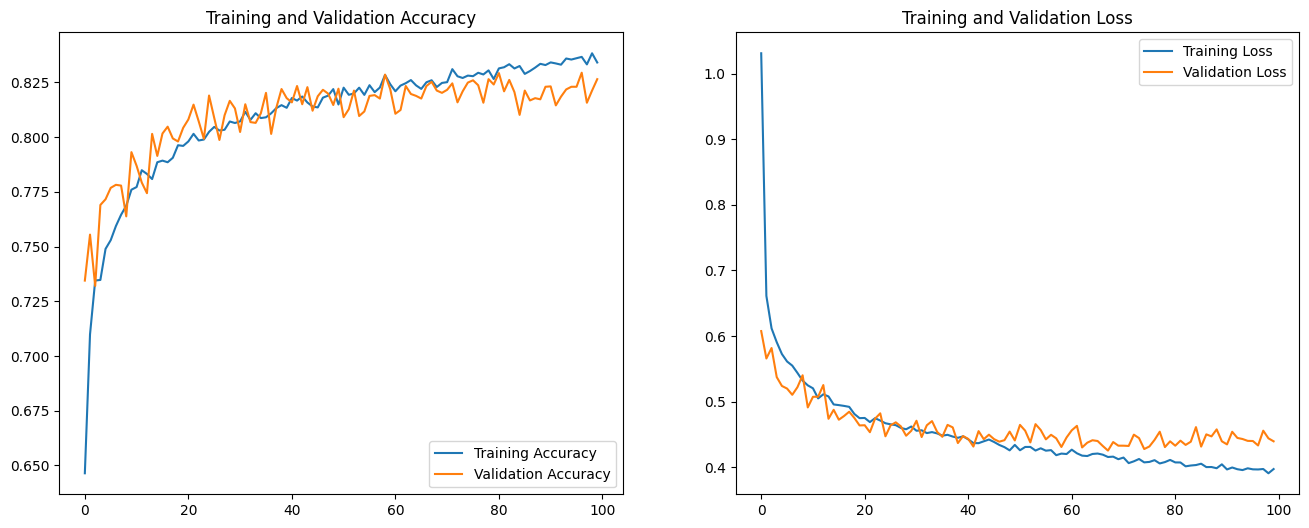

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 46ms/step - loss: 0.9426 - accuracy: 0.6412 - val_loss: 0.6243 - val_accuracy: 0.7275
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.6915 - accuracy: 0.7001 - val_loss: 0.5964 - val_accuracy: 0.7423
Epoch 3/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6422 - accuracy: 0.7232 - val_loss: 0.5587 - val_accuracy: 0.7619
Epoch 4/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6308 - accuracy: 0.7248 - val_loss: 0.5536 - val_accuracy: 0.7636
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6146 - accuracy: 0.7334 - val_loss: 0.5645 - val_accuracy: 0.7572
Epoch 6/100
360/360 [==============================] - 16s 44ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4755 - accuracy: 0.8003 - val_loss: 0.4627 - val_accuracy: 0.8044
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4742 - accuracy: 0.8024 - val_loss: 0.4632 - val_accuracy: 0.8079
Epoch 58/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4720 - accuracy: 0.8066 - val_loss: 0.4615 - val_accuracy: 0.8032
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4673 - accuracy: 0.8003 - val_loss: 0.4631 - val_accuracy: 0.8060
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4728 - accuracy: 0.8004 - val_loss: 0.4606 - val_accuracy: 0.8076
Epoch 61/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4723 - accuracy: 0.8021 - val_loss: 0.4570 - val_accuracy: 0.8088
Epoch 62/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4703 - accuracy: 0.8017 - val_loss: 0.4606 -

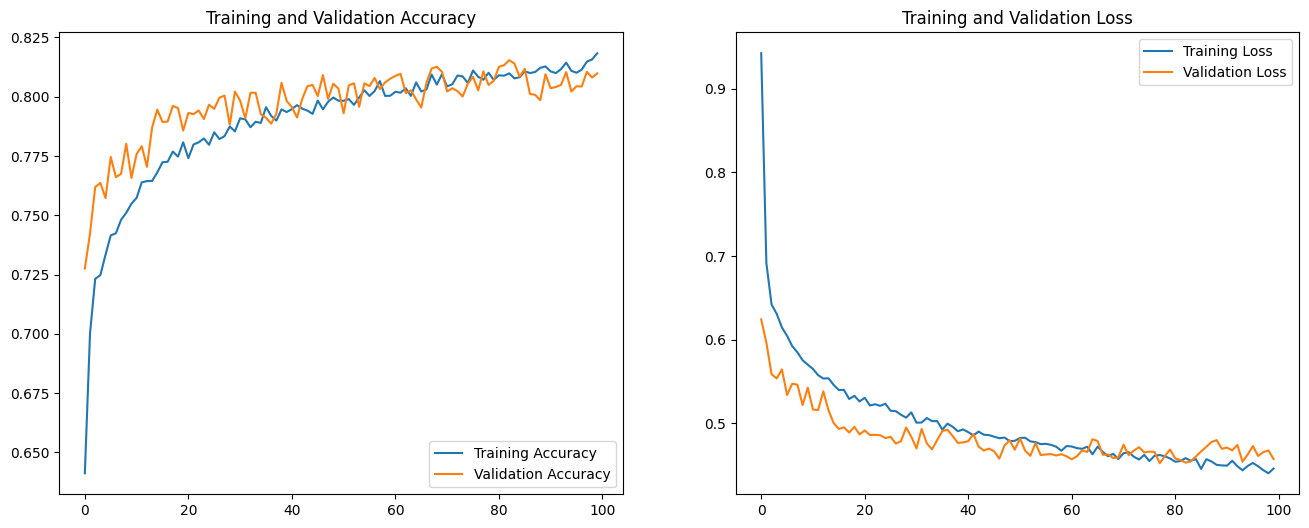

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 19s 45ms/step - loss: 0.9061 - accuracy: 0.6272 - val_loss: 0.6888 - val_accuracy: 0.6933
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.7323 - accuracy: 0.6818 - val_loss: 0.6600 - val_accuracy: 0.7159
Epoch 3/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6961 - accuracy: 0.6968 - val_loss: 0.6882 - val_accuracy: 0.6936
Epoch 4/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6737 - accuracy: 0.7121 - val_loss: 0.6512 - val_accuracy: 0.7122
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6514 - accuracy: 0.7216 - val_loss: 0.5980 - val_accuracy: 0.7423
Epoch 6/100
360/360 [==============================] - 16s 45ms/step - loss: 0.6399 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5055 - accuracy: 0.7928 - val_loss: 0.5067 - val_accuracy: 0.7972
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4993 - accuracy: 0.7951 - val_loss: 0.5058 - val_accuracy: 0.7939
Epoch 58/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5019 - accuracy: 0.7940 - val_loss: 0.4972 - val_accuracy: 0.8043
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5011 - accuracy: 0.7979 - val_loss: 0.5106 - val_accuracy: 0.7933
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4980 - accuracy: 0.7989 - val_loss: 0.4981 - val_accuracy: 0.8025
Epoch 61/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5001 - accuracy: 0.7955 - val_loss: 0.5150 - val_accuracy: 0.7926
Epoch 62/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4988 - accuracy: 0.7951 - val_loss: 0.4989 -

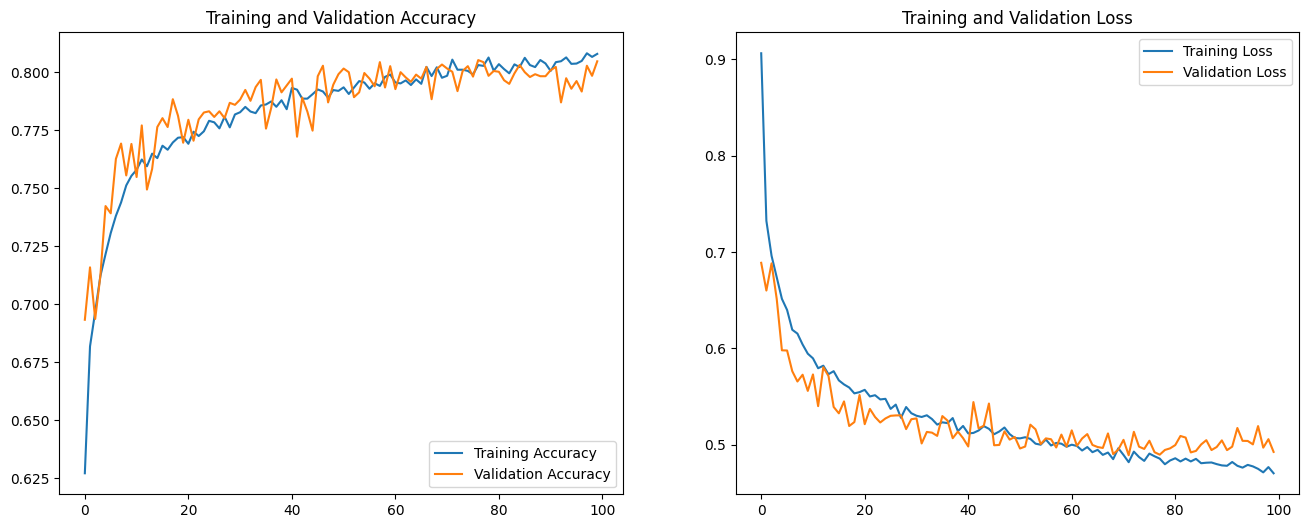

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.6568 - accuracy: 0.2808 - val_loss: 1.4177 - val_accuracy: 0.2890
Epoch 2/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4385 - accuracy: 0.2850 - val_loss: 1.4154 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4292 - accuracy: 0.2899 - val_loss: 1.4253 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4270 - accuracy: 0.2842 - val_loss: 1.4199 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4255 - accuracy: 0.2900 - val_loss: 1.4135 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 16s 43ms/step - loss: 1.

Epoch 58/100
360/360 [==============================] - 16s 44ms/step - loss: 1.3928 - accuracy: 0.3534 - val_loss: 1.3651 - val_accuracy: 0.3689
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 1.3912 - accuracy: 0.3516 - val_loss: 1.3596 - val_accuracy: 0.4173
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 1.3967 - accuracy: 0.3446 - val_loss: 1.3631 - val_accuracy: 0.4279
Epoch 61/100
360/360 [==============================] - 16s 44ms/step - loss: 1.3929 - accuracy: 0.3474 - val_loss: 1.3612 - val_accuracy: 0.4182
Epoch 62/100
360/360 [==============================] - 16s 44ms/step - loss: 1.3942 - accuracy: 0.3440 - val_loss: 1.3564 - val_accuracy: 0.4092
Epoch 63/100
360/360 [==============================] - 15s 43ms/step - loss: 1.3891 - accuracy: 0.3522 - val_loss: 1.3533 - val_accuracy: 0.4107
Epoch 64/100
360/360 [==============================] - 15s 43ms/step - loss: 1.3920 - accuracy: 0.3507 - val_loss: 1.3659 -

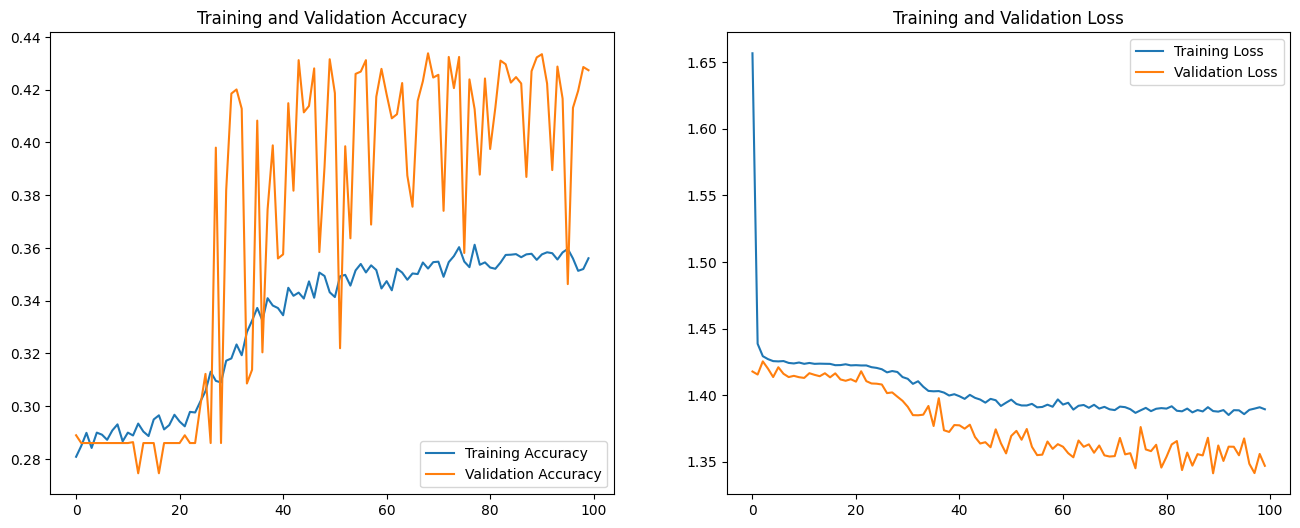

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 19s 48ms/step - loss: 1.1889 - accuracy: 0.4791 - val_loss: 1.0100 - val_accuracy: 0.5667
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 1.0318 - accuracy: 0.5583 - val_loss: 0.9784 - val_accuracy: 0.5967
Epoch 3/100
360/360 [==============================] - 16s 43ms/step - loss: 0.9793 - accuracy: 0.5807 - val_loss: 0.9295 - val_accuracy: 0.5809
Epoch 4/100
360/360 [==============================] - 16s 43ms/step - loss: 0.9599 - accuracy: 0.5879 - val_loss: 0.8650 - val_accuracy: 0.6264
Epoch 5/100
360/360 [==============================] - 15s 43ms/step - loss: 0.9362 - accuracy: 0.6002 - val_loss: 0.8512 - val_accuracy: 0.6370
Epoch 6/100
360/360 [==============================] - 16s 43ms/step - loss: 0.9253 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 15s 43ms/step - loss: 0.7480 - accuracy: 0.6959 - val_loss: 0.6947 - val_accuracy: 0.7094
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 0.7611 - accuracy: 0.6883 - val_loss: 0.7052 - val_accuracy: 0.7107
Epoch 58/100
360/360 [==============================] - 15s 43ms/step - loss: 0.7514 - accuracy: 0.6912 - val_loss: 0.6791 - val_accuracy: 0.7190
Epoch 59/100
360/360 [==============================] - 16s 43ms/step - loss: 0.7513 - accuracy: 0.6912 - val_loss: 0.6693 - val_accuracy: 0.7372
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.7464 - accuracy: 0.6917 - val_loss: 0.6987 - val_accuracy: 0.7020
Epoch 61/100
360/360 [==============================] - 16s 43ms/step - loss: 0.7482 - accuracy: 0.6913 - val_loss: 0.6696 - val_accuracy: 0.7244
Epoch 62/100
360/360 [==============================] - 16s 43ms/step - loss: 0.7531 - accuracy: 0.6946 - val_loss: 0.6614 -

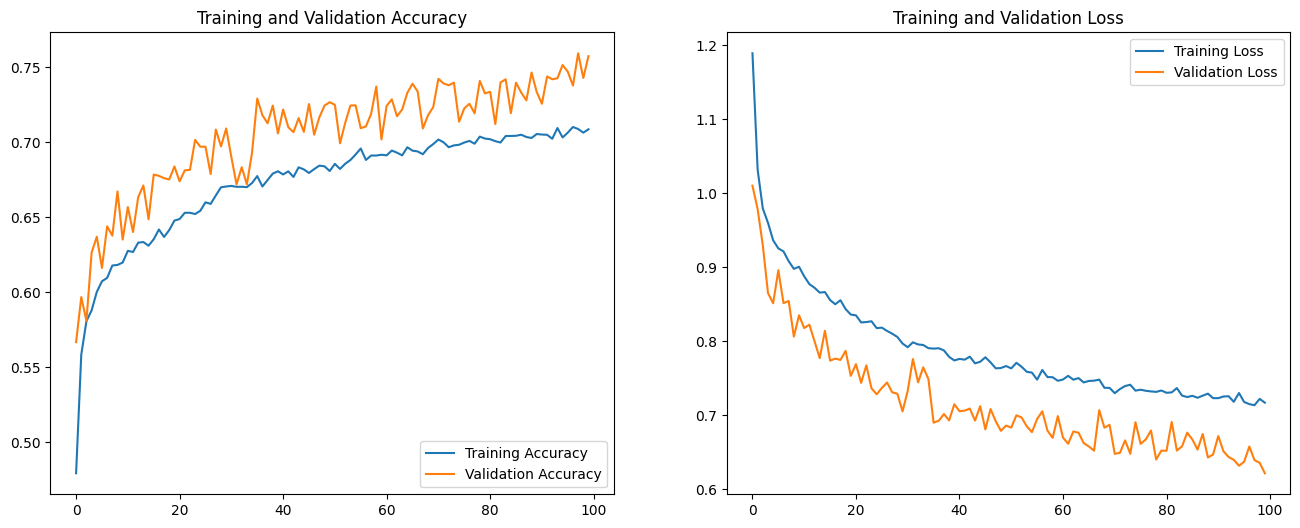

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.6578 - accuracy: 0.2790 - val_loss: 1.4290 - val_accuracy: 0.3044
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 1.4407 - accuracy: 0.2919 - val_loss: 1.4111 - val_accuracy: 0.3937
Epoch 3/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4221 - accuracy: 0.3026 - val_loss: 1.3908 - val_accuracy: 0.3430
Epoch 4/100
360/360 [==============================] - 16s 43ms/step - loss: 1.4075 - accuracy: 0.3126 - val_loss: 1.3904 - val_accuracy: 0.3854
Epoch 5/100
360/360 [==============================] - 16s 43ms/step - loss: 1.3937 - accuracy: 0.3278 - val_loss: 1.4021 - val_accuracy: 0.3187
Epoch 6/100
360/360 [==============================] - 15s 43ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 15s 42ms/step - loss: 1.3033 - accuracy: 0.3928 - val_loss: 1.3283 - val_accuracy: 0.3727
Epoch 57/100
360/360 [==============================] - 15s 42ms/step - loss: 1.3029 - accuracy: 0.3948 - val_loss: 1.2670 - val_accuracy: 0.4126
Epoch 58/100
360/360 [==============================] - 15s 43ms/step - loss: 1.2964 - accuracy: 0.4002 - val_loss: 1.3089 - val_accuracy: 0.3883
Epoch 59/100
360/360 [==============================] - 15s 43ms/step - loss: 1.3024 - accuracy: 0.3972 - val_loss: 1.2659 - val_accuracy: 0.4151
Epoch 60/100
360/360 [==============================] - 17s 49ms/step - loss: 1.3040 - accuracy: 0.3942 - val_loss: 1.2607 - val_accuracy: 0.4149
Epoch 61/100
360/360 [==============================] - 16s 43ms/step - loss: 1.3012 - accuracy: 0.3919 - val_loss: 1.2601 - val_accuracy: 0.4140
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 1.3024 - accuracy: 0.3950 - val_loss: 1.2568 -

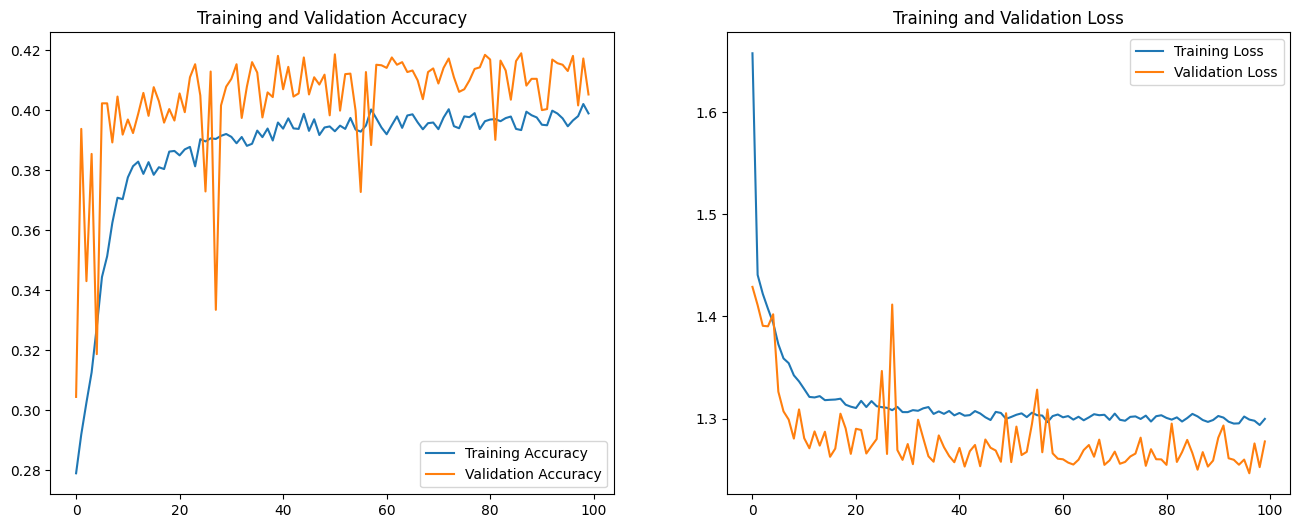

In [10]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 43ms/step - loss: 0.9330 - accuracy: 0.5987 - val_loss: 0.7856 - val_accuracy: 0.6540
Epoch 2/100
360/360 [==============================] - 15s 42ms/step - loss: 0.8212 - accuracy: 0.6428 - val_loss: 0.7508 - val_accuracy: 0.6721
Epoch 3/100
360/360 [==============================] - 15s 42ms/step - loss: 0.7982 - accuracy: 0.6535 - val_loss: 0.7578 - val_accuracy: 0.6737
Epoch 4/100
360/360 [==============================] - 15s 42ms/step - loss: 0.7873 - accuracy: 0.6579 - val_loss: 0.7511 - val_accuracy: 0.6674
Epoch 5/100
360/360 [==============================] - 15s 43ms/step - loss: 0.7720 - accuracy: 0.6653 - val_loss: 0.7304 - val_accuracy: 0.6789
Epoch 6/100
360/360 [==============================] - 15s 42ms/step - loss: 0.7643 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6382 - accuracy: 0.7330 - val_loss: 0.6198 - val_accuracy: 0.7424
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6303 - accuracy: 0.7397 - val_loss: 0.6125 - val_accuracy: 0.7447
Epoch 58/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6265 - accuracy: 0.7405 - val_loss: 0.6278 - val_accuracy: 0.7360
Epoch 59/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6326 - accuracy: 0.7347 - val_loss: 0.6298 - val_accuracy: 0.7426
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6274 - accuracy: 0.7400 - val_loss: 0.6269 - val_accuracy: 0.7419
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6347 - accuracy: 0.7384 - val_loss: 0.6208 - val_accuracy: 0.7414
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6282 - accuracy: 0.7402 - val_loss: 0.6271 -

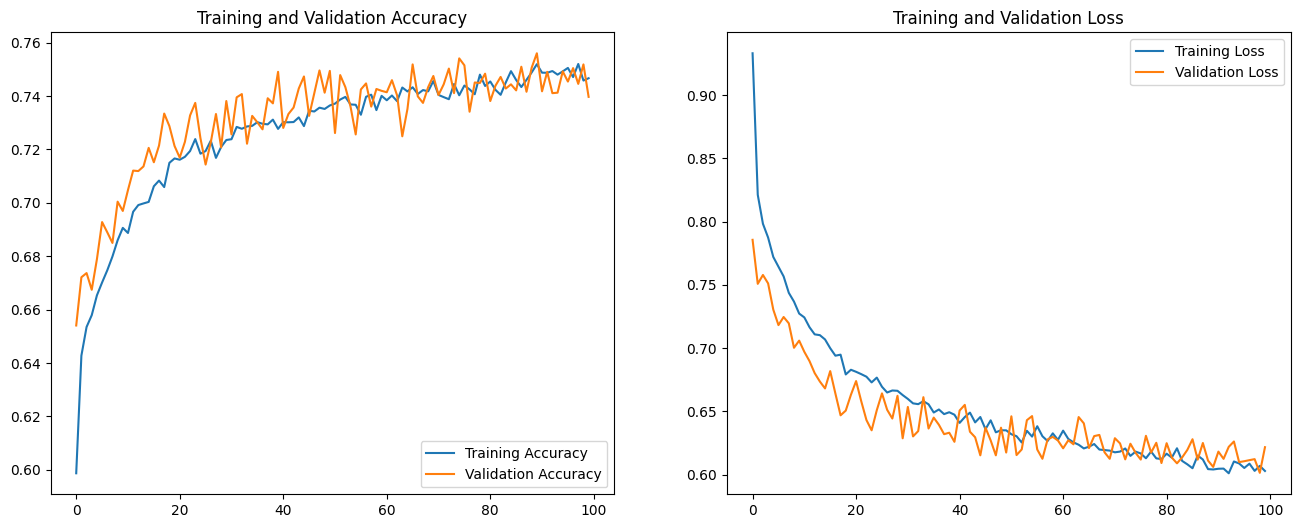

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 45ms/step - loss: 1.6202 - accuracy: 0.2792 - val_loss: 1.4151 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 16s 44ms/step - loss: 1.4263 - accuracy: 0.2913 - val_loss: 1.4137 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 15s 42ms/step - loss: 1.4253 - accuracy: 0.2896 - val_loss: 1.4133 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4242 - accuracy: 0.2897 - val_loss: 1.4197 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 15s 42ms/step - loss: 1.4234 - accuracy: 0.2944 - val_loss: 1.4127 - val_accuracy: 0.2746
Epoch 6/100
360/360 [==============================] - 15s 43ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4214 - accuracy: 0.2931 - val_loss: 1.4145 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4222 - accuracy: 0.2920 - val_loss: 1.4141 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 18s 49ms/step - loss: 1.4213 - accuracy: 0.2928 - val_loss: 1.4202 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4218 - accuracy: 0.2943 - val_loss: 1.4115 - val_accuracy: 0.2890
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4217 - accuracy: 0.2923 - val_loss: 1.4114 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4214 - accuracy: 0.2935 - val_loss: 1.4134 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4222 - accuracy: 0.2929 - val_loss: 1.4112 -

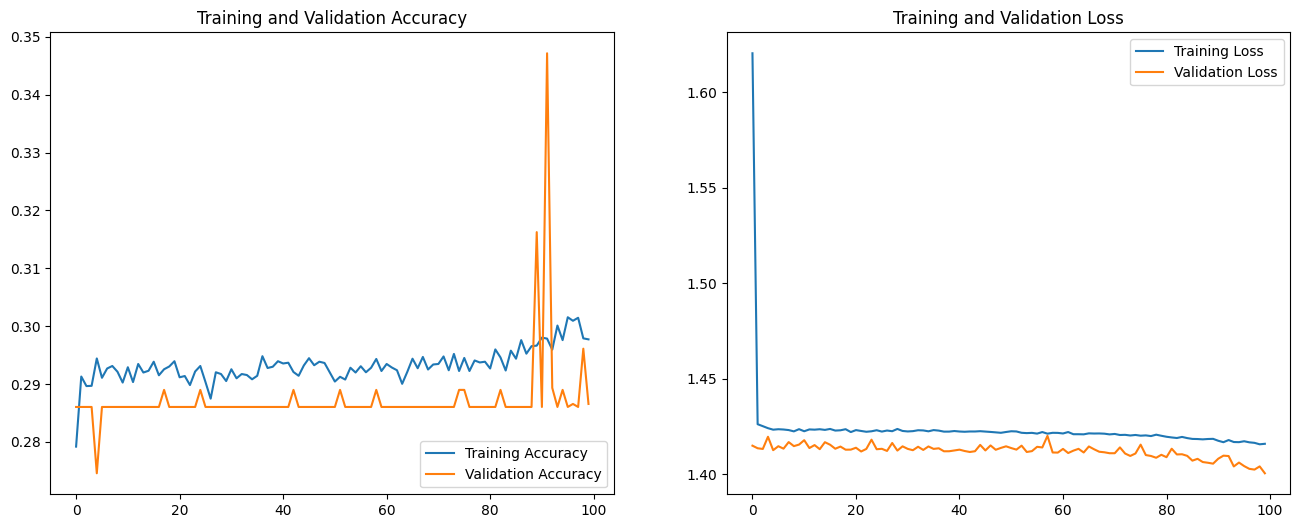

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.2087 - accuracy: 0.4507 - val_loss: 0.9473 - val_accuracy: 0.5922
Epoch 2/100
360/360 [==============================] - 16s 44ms/step - loss: 0.9927 - accuracy: 0.5666 - val_loss: 0.8711 - val_accuracy: 0.6101
Epoch 3/100
360/360 [==============================] - 16s 44ms/step - loss: 0.9326 - accuracy: 0.5964 - val_loss: 0.8453 - val_accuracy: 0.6346
Epoch 4/100
360/360 [==============================] - 16s 44ms/step - loss: 0.8960 - accuracy: 0.6163 - val_loss: 0.7941 - val_accuracy: 0.6636
Epoch 5/100
360/360 [==============================] - 16s 43ms/step - loss: 0.8823 - accuracy: 0.6181 - val_loss: 0.8558 - val_accuracy: 0.6077
Epoch 6/100
360/360 [==============================] - 15s 43ms/step - loss: 0.8605 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6518 - accuracy: 0.7363 - val_loss: 0.5526 - val_accuracy: 0.7822
Epoch 57/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6490 - accuracy: 0.7351 - val_loss: 0.5827 - val_accuracy: 0.7638
Epoch 58/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6517 - accuracy: 0.7419 - val_loss: 0.5607 - val_accuracy: 0.7895
Epoch 59/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6556 - accuracy: 0.7353 - val_loss: 0.5847 - val_accuracy: 0.7591
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6510 - accuracy: 0.7372 - val_loss: 0.5916 - val_accuracy: 0.7680
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6501 - accuracy: 0.7428 - val_loss: 0.5685 - val_accuracy: 0.7742
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6537 - accuracy: 0.7383 - val_loss: 0.5573 -

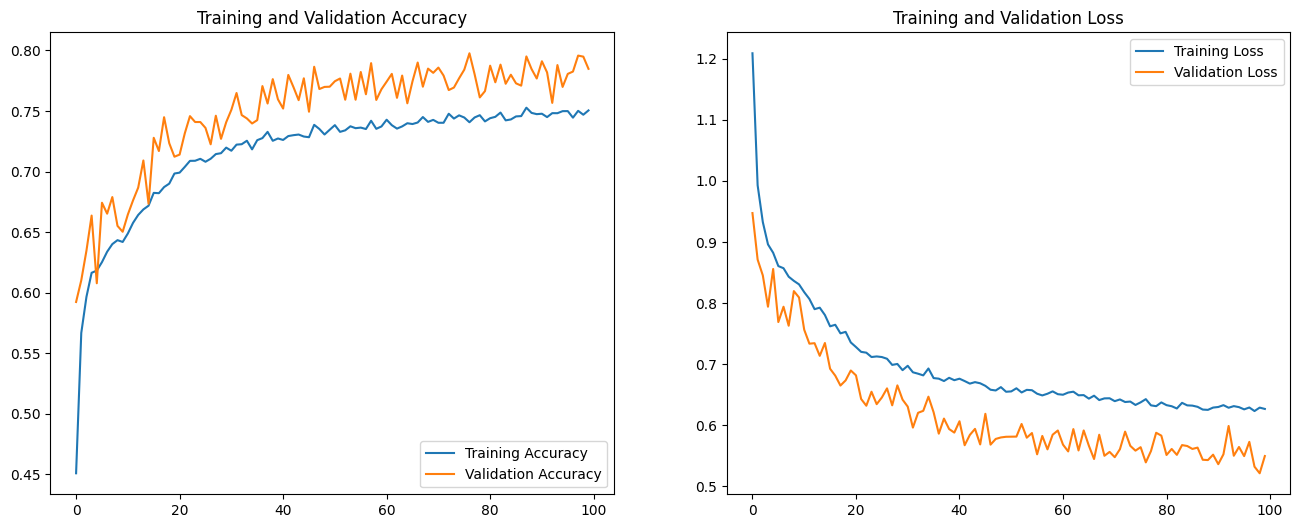

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.6294 - accuracy: 0.2737 - val_loss: 1.4200 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4456 - accuracy: 0.2840 - val_loss: 1.4163 - val_accuracy: 0.2746
Epoch 3/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4344 - accuracy: 0.2843 - val_loss: 1.4336 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4296 - accuracy: 0.2849 - val_loss: 1.4280 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4269 - accuracy: 0.2836 - val_loss: 1.4155 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 15s 43ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4222 - accuracy: 0.2937 - val_loss: 1.4135 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4227 - accuracy: 0.2936 - val_loss: 1.4154 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4227 - accuracy: 0.2916 - val_loss: 1.4142 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4225 - accuracy: 0.2944 - val_loss: 1.4124 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4227 - accuracy: 0.2911 - val_loss: 1.4140 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 1.4228 - accuracy: 0.2946 - val_loss: 1.4123 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 16s 43ms/step - loss: 1.4226 - accuracy: 0.2919 - val_loss: 1.4122 -

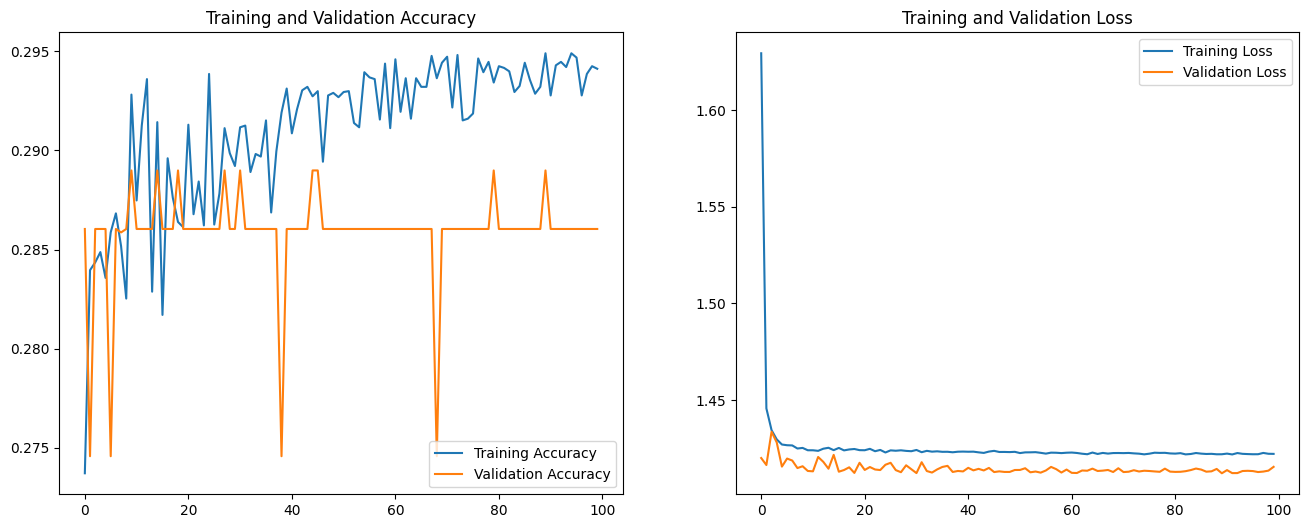

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 19s 46ms/step - loss: 1.1413 - accuracy: 0.4861 - val_loss: 0.9473 - val_accuracy: 0.5761
Epoch 2/100
360/360 [==============================] - 15s 43ms/step - loss: 0.9665 - accuracy: 0.5802 - val_loss: 0.8642 - val_accuracy: 0.6301
Epoch 3/100
360/360 [==============================] - 15s 43ms/step - loss: 0.9258 - accuracy: 0.5965 - val_loss: 0.8339 - val_accuracy: 0.6334
Epoch 4/100
360/360 [==============================] - 16s 43ms/step - loss: 0.9035 - accuracy: 0.6109 - val_loss: 0.8238 - val_accuracy: 0.6415
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.8824 - accuracy: 0.6207 - val_loss: 0.8193 - val_accuracy: 0.6471
Epoch 6/100
360/360 [==============================] - 16s 44ms/step - loss: 0.8665 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 16s 43ms/step - loss: 0.7001 - accuracy: 0.7143 - val_loss: 0.6583 - val_accuracy: 0.7310
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6956 - accuracy: 0.7170 - val_loss: 0.6157 - val_accuracy: 0.7582
Epoch 58/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6989 - accuracy: 0.7135 - val_loss: 0.6076 - val_accuracy: 0.7648
Epoch 59/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6892 - accuracy: 0.7201 - val_loss: 0.6232 - val_accuracy: 0.7473
Epoch 60/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6927 - accuracy: 0.7177 - val_loss: 0.6240 - val_accuracy: 0.7543
Epoch 61/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6907 - accuracy: 0.7172 - val_loss: 0.6113 - val_accuracy: 0.7485
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6987 - accuracy: 0.7156 - val_loss: 0.6165 -

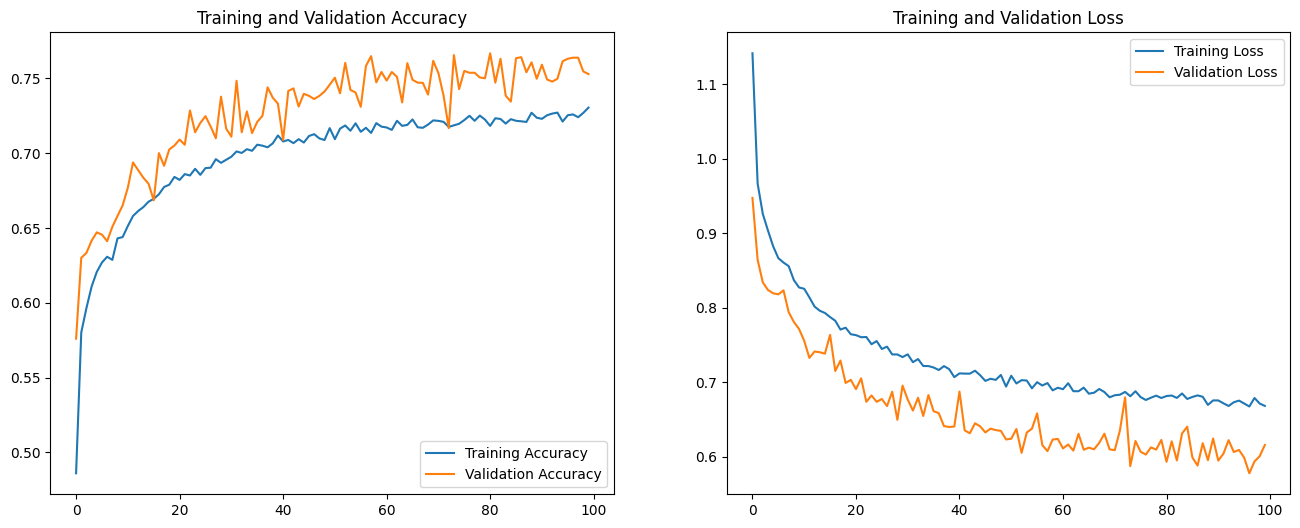

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
!mkdir vgg19_nontrainable
pd.DataFrame(res_rgb).to_csv("vgg19_nontrainable/res_rgb.csv", index=False)
pd.DataFrame(res_lab_pre).to_csv("vgg19_nontrainable/res_lab_pre.csv", index=False)
pd.DataFrame(res_lab_nonpre).to_csv("vgg19_nontrainable/res_lab_nonpre.csv", index=False)
pd.DataFrame(res_xyz_pre).to_csv("vgg19_nontrainable/res_xyz_pre.csv", index=False)
pd.DataFrame(res_xyz_nonpre).to_csv("vgg19_nontrainable/res_xyz_nonpre.csv", index=False)
pd.DataFrame(res_hsv_pre).to_csv("vgg19_nontrainable/res_hsv_pre.csv", index=False)
pd.DataFrame(res_hsv_nonpre).to_csv("vgg19_nontrainable/res_hsv_nonpre.csv", index=False)
pd.DataFrame(res_yuv_pre).to_csv("vgg19_nontrainable/res_yuv_pre.csv", index=False)
pd.DataFrame(res_yuv_nonpre).to_csv("vgg19_nontrainable/res_yuv_nonpre.csv", index=False)
pd.DataFrame(res_ydbdr_pre).to_csv("vgg19_nontrainable/res_ydbdr_pre.csv", index=False)
pd.DataFrame(res_ydbdr_nonpre).to_csv("vgg19_nontrainable/res_ydbdr_nonpre.csv", index=False)